Maybe we define new structure which captures the input parameters specific to each problem in one place (`scale_factor`).
We need to define a range on `d` that is also function dependent (that we could adjust by hand). 

We need to generate three graphs: 
- Histogram of Number of `loc_min` points were found, (so outputs of the Optim routine) and what percentage of them is within a small distance of a critical point of the approximant. As a function of the degree `d` of the approximant.


In [9]:
using Pkg
using Revise 
Pkg.activate("../../.")
using Globtim
using DynamicPolynomials, DataFrames
using ProgressLogging
using Optim
using CairoMakie
CairoMakie.activate!

  Activating project at `~/globtim`


activate! (generic function with 1 method)

In [10]:
kwel = Globtim.GaussianParams([0.26089820418282555 0.7344607224948916; -0.03017402660215973 -0.08830141199871192; -0.5923178162494483 0.7056820121831168; 0.17219769077638444 0.23048326052302262; -0.24763641218779517 -0.7815397497735926; -0.4673401509337077 -0.20722331050611642; -0.7477436163328894 -0.2190129770253087; -0.001999373470356236 -0.2950834352880266; -0.3120301213620158 0.16354534796517442; 0.69272872993026 0.4029772296623259; -0.5931618012868126 -0.7334896493870542; -0.7295746099547044 0.01794672027273103], [0.3594863378910475, 0.26981260289694575, 0.5230637389101772, 0.1277917080242205, 0.11533967613820623, 0.38278982674149603, 0.45620512616814934, 0.1910983217345807, 0.2170627012236726, 0.4817586065231313, 0.0952629299826123, 0.5767317212090373], [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0])

rand_gaussian_closure = (x) -> rand_gaussian(x, kwel)
f = rand_gaussian_closure;
f([1.0, 1.0])

0.2809394252526073

Can a function export "Optional attributes" like just some constants or its optimal domain of definition? --> works. 

In [11]:
d_min, d_max = 3, 30
TD = 0.1
params = load_function_params("gaussian")
TR = test_input(f;
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=params.tolerance)

@polyvar(x[1:TR.dim]); # Define polynomial ring 

In [12]:
results = analyze_degrees(TR, x, d_min, d_max, step=1, tol_dist=TD)

current L2-norm: 0.8866910562761793
Dimension m of the vector space: 10

=== Starting MSolve Parser (dimension: 2) ===
Processed 4 points (0.0s)
Processing point 1 of 2
Optimization status: ✗ (outside bounds)
Processing point 2 of 2
Optimization status: ✗ (outside bounds)
current L2-norm: 0.666142271267489
Dimension m of the vector space: 15

=== Starting MSolve Parser (dimension: 2) ===
Processed 7 points (0.0s)
Processing point 1 of 4
Optimization has converged within bounds: ✓
Processing point 2 of 4
Optimization status: ✗ (outside bounds)
Processing point 3 of 4
Optimization status: ✗ (outside bounds)
Processing point 4 of 4
Optimization has converged within bounds: ✓
current L2-norm: 0.5687612516358402
Dimension m of the vector space: 21

=== Starting MSolve Parser (dimension: 2) ===
Processed 10 points (0.0s)
Processing point 1 of 6
Optimization status: ✗ (outside bounds)
Processing point 2 of 6
Optimization has converged within bounds: ✓
Processing point 3 of 6
Optimization stat

Dict{Int64, @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}} with 28 entries:
  5  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  16 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  20 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  12 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  24 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  28 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  8  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  17 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  30 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  23 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  19 => @NamedTuple{df::DataFrame, df_min::DataFrame, converg

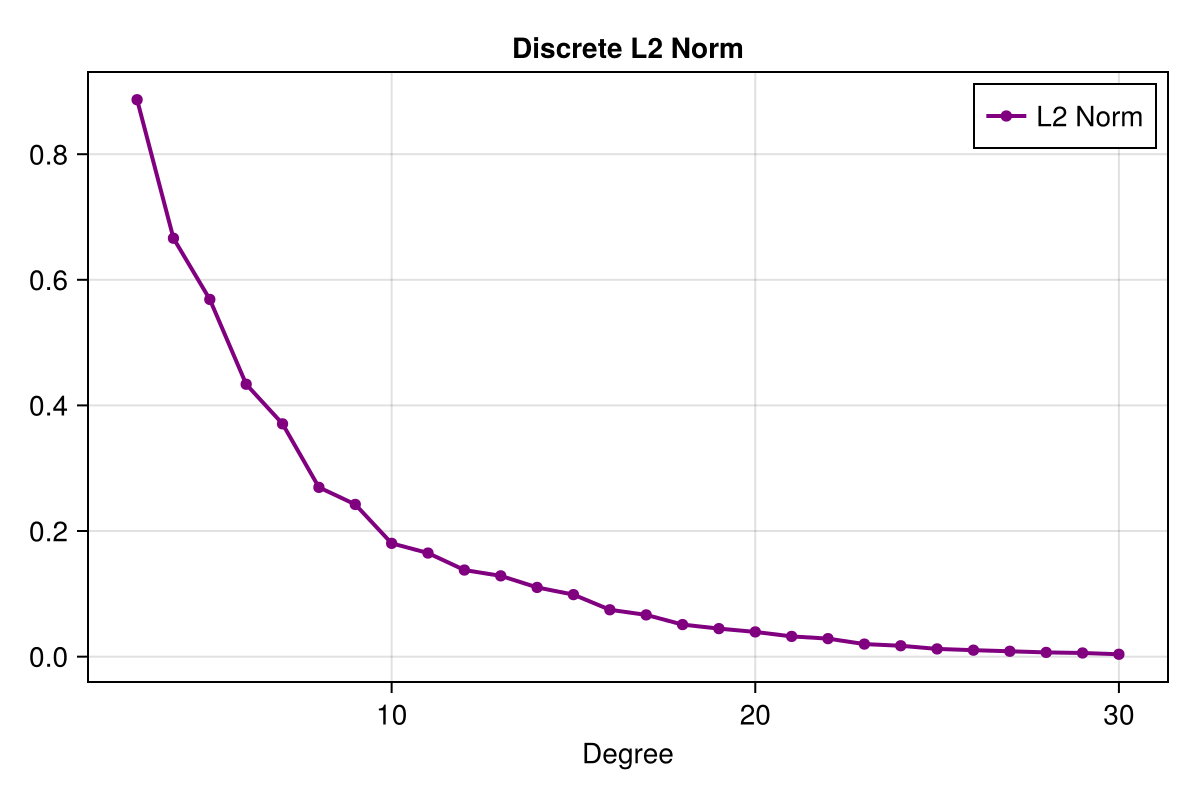

CairoMakie.Screen{IMAGE}


In [13]:
fig_1 = plot_discrete_l2(new_results, d_min, d_max, 1)
# save("discrete_l2.pdf", fig_1)
display(fig_1)

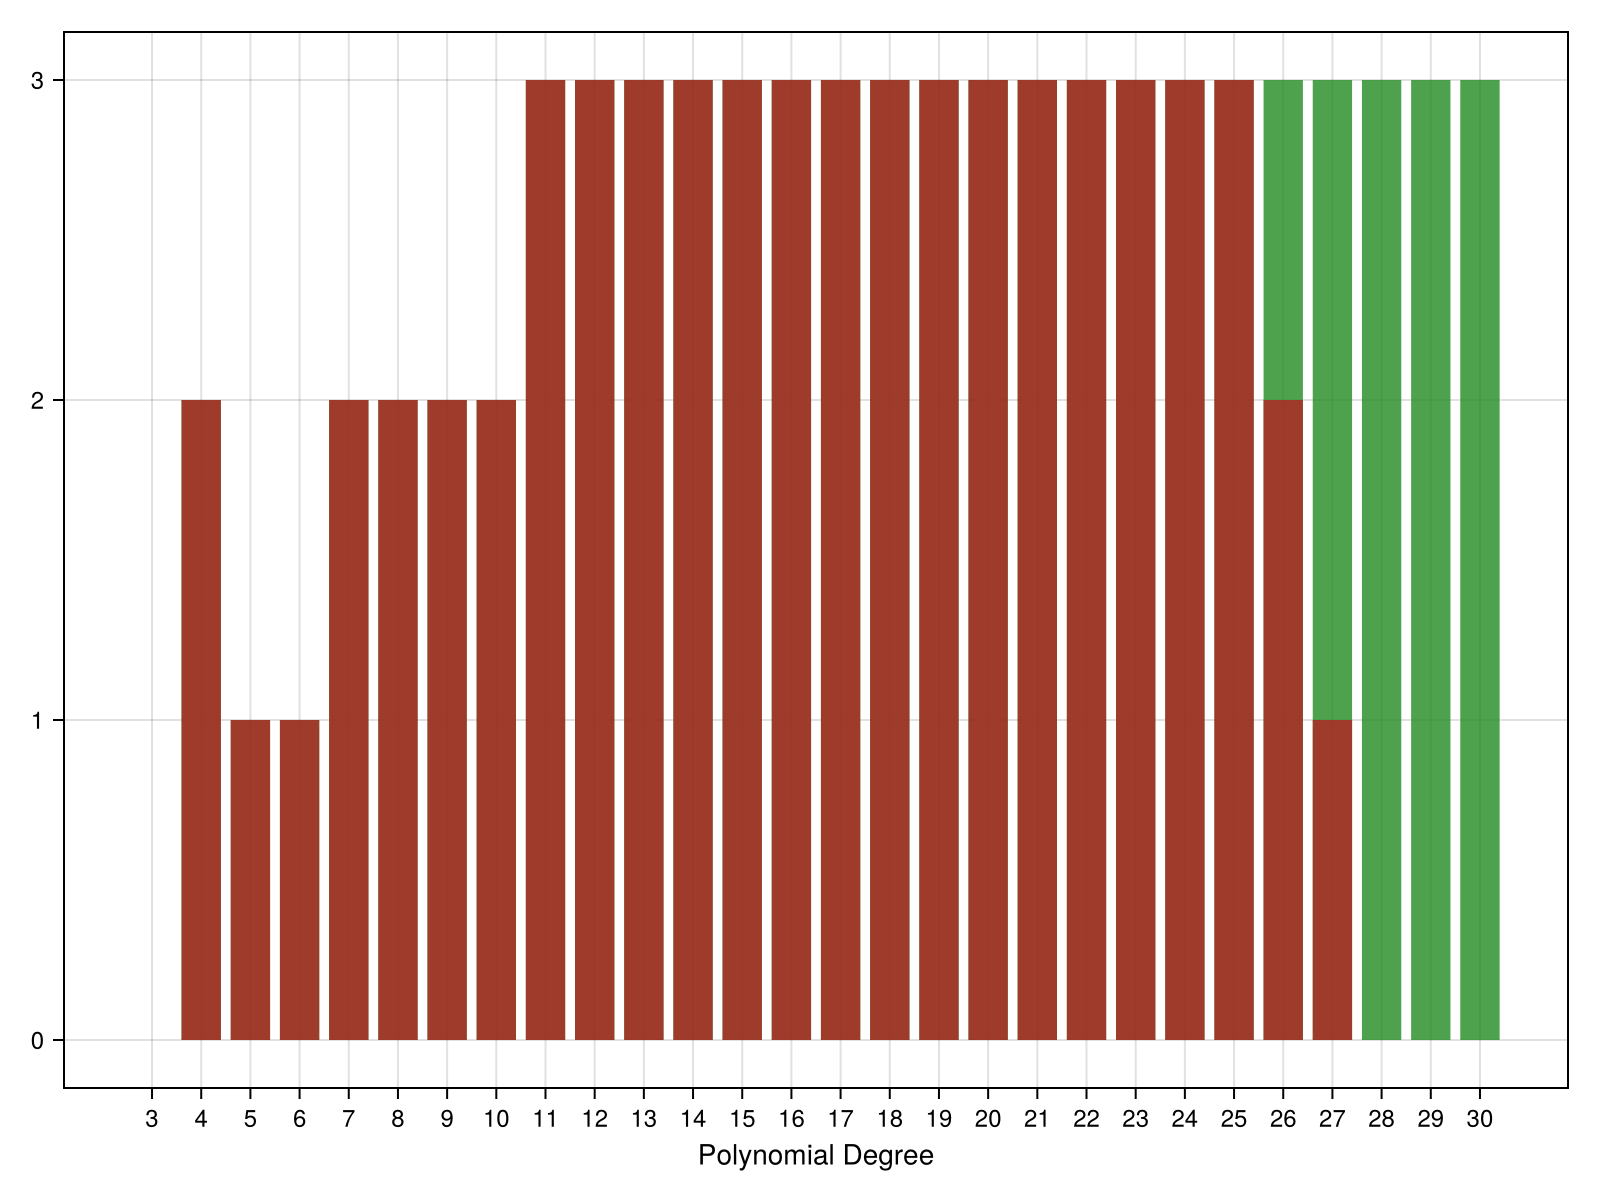

CairoMakie.Screen{IMAGE}


In [14]:
fig_2 = capture_histogram(new_results, d_min, d_max, 1, show_legend=false)
# save("histogram.pdf", fig_2)
display(fig_2)

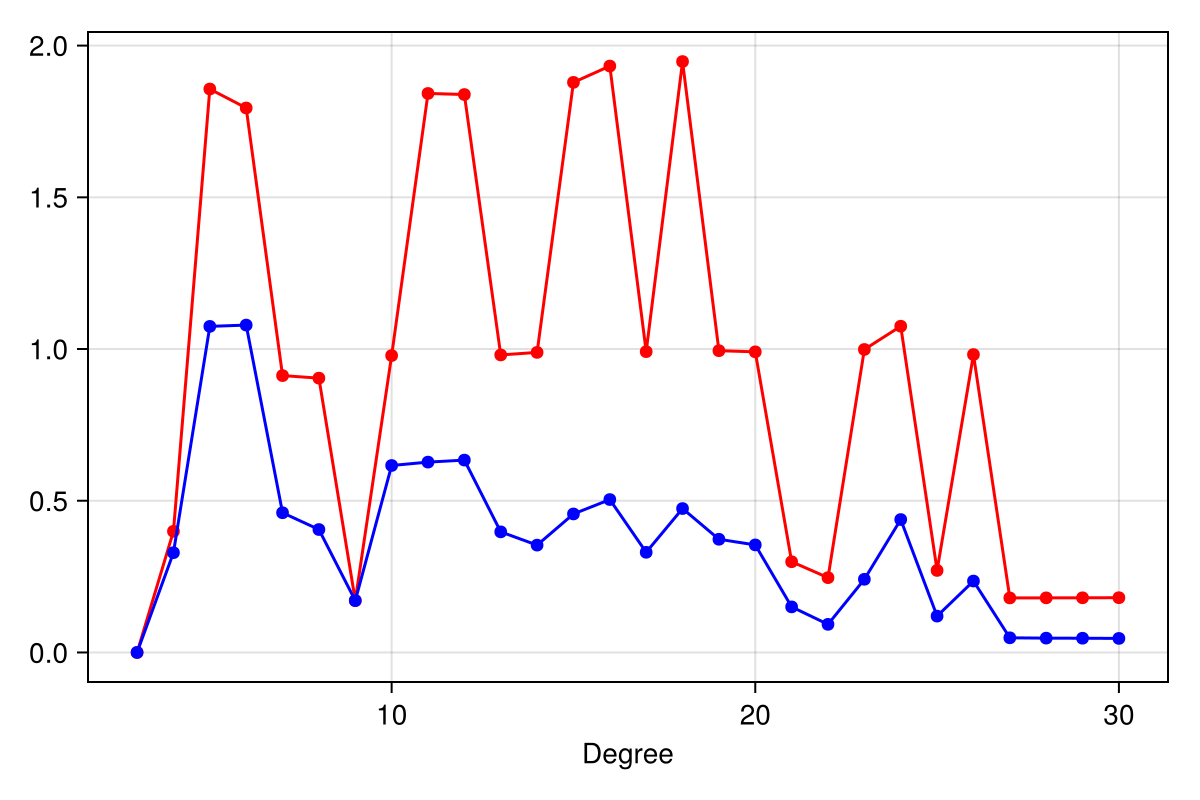

CairoMakie.Screen{IMAGE}


In [16]:
fig_3 = plot_convergence_analysis(results, d_min, d_max, 1, show_legend=false)
# save("convergence_analysis.pdf", fig_3)
display(fig_3)

In [21]:
RT = results[28]
df_t = RT.df
df_m = RT.df_min;
inside_mask = points_in_hypercube(df_t, TR)
values_mask = points_in_range(df_t, TR, .8)
df_minimizers = df_t[values_mask.&inside_mask, :] # has both `x` (raw) and `y` (optimized)
pol_cheb = Constructor(TR, 8, basis=:chebyshev);


current L2-norm: 0.26953063162008


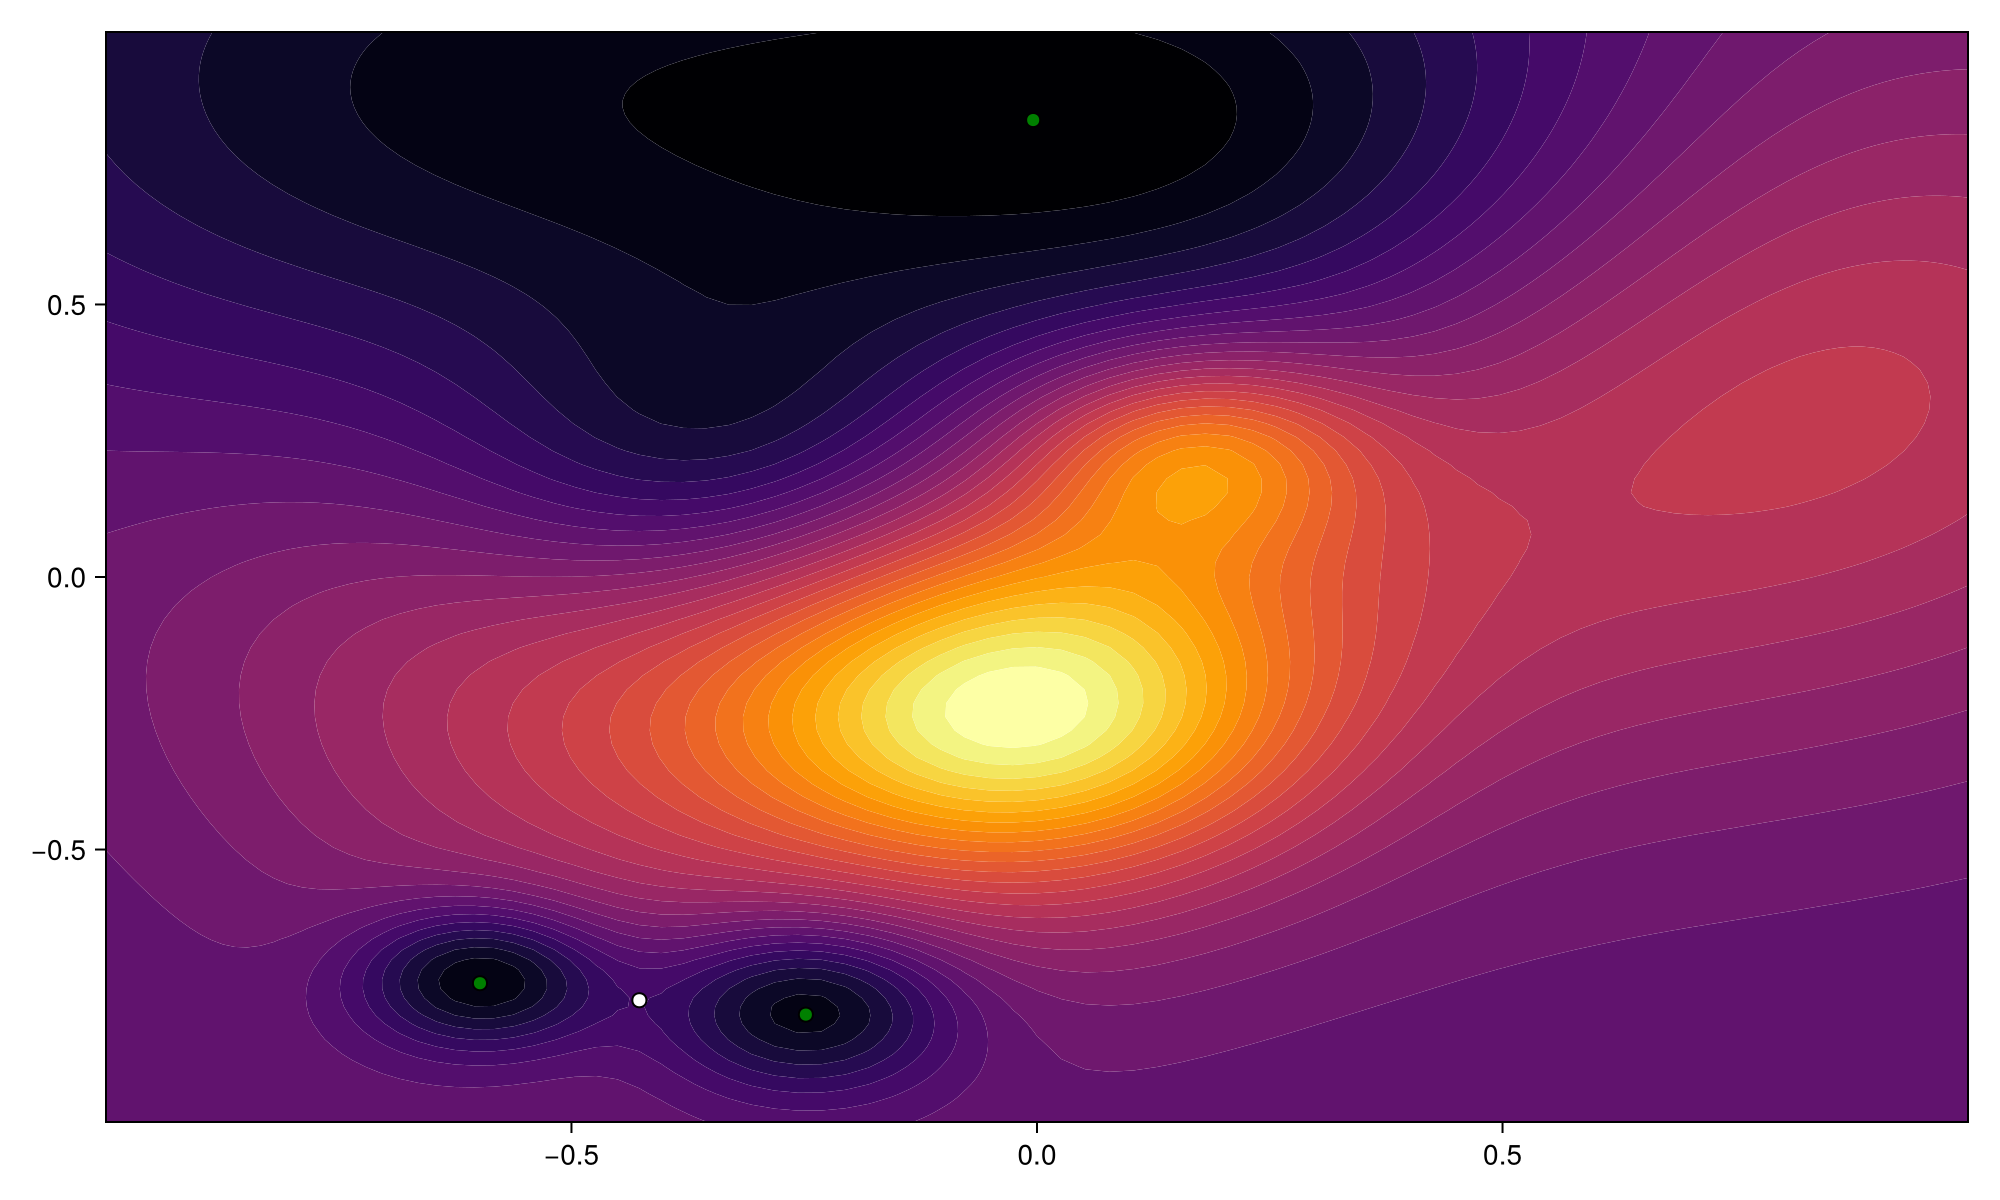

In [26]:
fig_4 = cairo_plot_polyapprox_levelset(pol_cheb, TR, df_minimizers, df_m, show_captured=false)

In [38]:
stats = analyze_converged_points(df_minimizers, TR, results, d_min, d_max, 1)
avg_distances = stats["avg_distances"]


28-element Vector{Float64}:
 0.8868646602165364
 0.37802035062062256
 0.3304195446204792
 0.2646596400796879
 0.23281956826099826
 0.18442817212248275
 0.17674914041610418
 0.14919453185073825
 0.14348517834513147
 0.11648304197291369
 ⋮
 0.011264299210728565
 0.009813445455101157
 0.008176564510138758
 0.00700473262776272
 0.005055700069667847
 0.004413147256549118
 0.003011164697904357
 0.002484757317629471
 0.0016326241512733524

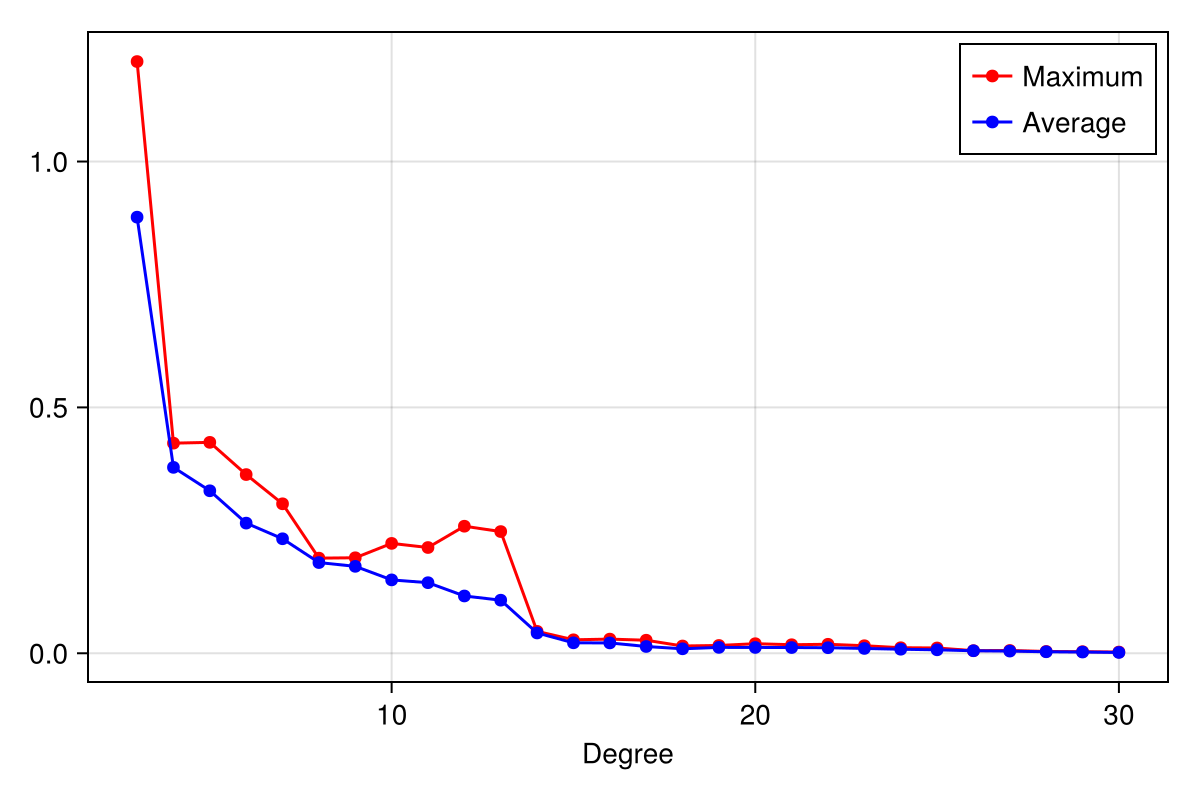

In [35]:
fig_5 = plot_distance_statistics(stats)
# save("distance_statistics.pdf", fig_5)